# 🦮🦠 Pet Disease classification 🦮🦠

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir -p ~/.kaggle
! mv kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import os, shutil

class DatasetYuklabOlish:
    def __init__(self, save_dir):
        self.save_dir = save_dir
        self.available_datasets = {
            "cars_detection": "kaggle datasets download -d killa92/car-detect-dataset",
            "car_brands": "kaggle datasets download mohamedaziz15/cars-brands-in-egypt",
            "geo_scene": "kaggle datasets download prithivsakthiur/multilabel-geoscenenet-16k",
            "facial_expression": "kaggle datasets download dollyprajapati182/balanced-raf-db-dataset-7575-grayscale",
            "pet_disease": "kaggle datasets download smadive/pet-disease-images",
            "apple_disease": "kaggle datasets download -d killa92/apple-disease-dataset",
            "insects": "kaggle datasets download -d killa92/arthropodia-semantic-segmentation-dataset",
            "crop": "kaggle datasets download -d killa92/crop-disease-image-classification-dataset",
            "dog_breeds": "kaggle datasets download yxshee/dogs-dataset",
            "rice_leaf_disease": "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset",
            "lentils": "kaggle datasets download -d killa92/lentils-classification-dataset",
            "brain": "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset",
            "flood": "kaggle datasets download killa92/flood-image-segmentation",
            "fruits": "kaggle datasets download -d killa92/fruits-classification-dataset",
            "aeroscapes": "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset",
            "cardiac": "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset",
            "vehicles": "kaggle datasets download -d killa92/vehicle-detection-dataset",
            "cloud": "kaggle datasets download -d killa92/cloud-quality-images-classification-dataset",
            "skin_lesion": "kaggle datasets download -d killa92/skin-lesion-image-ham-classification",
            "comments": "kaggle datasets download -d killa92/comments-nlp-sentiment-analysis-dataset",
            "3d_data": "kaggle datasets download glxslzt/3cla-adni",
            "50_car_brands": "kaggle datasets download yamaerenay/100-images-of-top-50-car-brands",
        }

    def yuklab_olish(self, dataset_name):
        assert dataset_name in self.available_datasets, f"Dataset nomi xato! Quyidagilardan birini kiriting:\n{list(self.available_datasets.keys())}"
        url = self.available_datasets[dataset_name]
        if url is None:
            print(f"{dataset_name} uchun hozircha URL mavjud emas.")
            return

        dataset_path = os.path.join(self.save_dir, dataset_name)
        if os.path.isdir(dataset_path) or os.path.isfile(dataset_path + ".csv"):
            print(f"Dataset allaqachon mavjud: {dataset_path}")
            return

        print(f"{dataset_name} dataset yuklab olinmoqda...")
        archive_dir = os.path.join(self.save_dir, url.split("/")[-1])
        os.makedirs(archive_dir, exist_ok=True)

        os.system(f"{url} -p {archive_dir}")

        zip_path = os.path.join(archive_dir, f"{url.split('/')[-1]}.zip")
        if os.path.exists(zip_path):
            shutil.unpack_archive(zip_path, archive_dir)
            os.remove(zip_path)

        # Rename folder if needed
        if not os.path.exists(dataset_path):
            os.rename(archive_dir, dataset_path)

        print(f"{dataset_name} dataset {dataset_path} ga muvaffaqiyatli yuklab olindi!")

yuklaboluvchi = DatasetYuklabOlish(save_dir="datasets")
yuklaboluvchi.yuklab_olish("pet_disease") # facial_expression; pet_disease

pet_disease dataset yuklab olinmoqda...
pet_disease dataset datasets/pet_disease ga muvaffaqiyatli yuklab olindi!


In [ ]:
import os, torch, random, shutil, numpy as np, pandas as pd
from glob import glob
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2025)

class CustomDataset(Dataset):

  def __init__(self, root, cls_names = None, transformations = None, im_files = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp']):

    self.transformations = transformations
    self.im_paths = glob(f"{root}/*/*{[im_file for im_file in im_files]}")
    # self.im_paths = glob(f"{root}/*/*.jpg")

    self.cls_names, self.cls_counts, count = {} if not cls_names else cls_names, {}, 0

    for idx, im_path  in enumerate(self.im_paths):
      cls_name = self.get_cls_name(im_path)
      if self.cls_names is not None:
        if cls_name not in self.cls_names:
          self.cls_names[cls_name] = count
          count += 1
      if cls_name not in self.cls_counts:
        self.cls_counts[cls_name] = 1
      else: self.cls_counts[cls_name] += 1


  def get_cls_name(self, path): return os.path.dirname(path).split("/")[-1]

  def __len__ (self): return len(self.im_paths)


  def get_pos_neg_im_path(self, qry_label):

    pos_im_paths = [im_path for im_path in self.im_paths if qry_label == self.get_cls_name(im_path)]
    neg_im_paths = [im_path for im_path in self.im_paths if qry_label != self.get_cls_name(im_path)]

    pos_rand_int = random.randint(a = 0, b = len(pos_im_paths) - 1)
    neg_rand_int = random.randint(a = 0, b = len(neg_im_paths) - 1)

    return pos_im_paths[pos_rand_int], neg_im_paths[neg_rand_int]

  def __getitem__(self, idx):

    im_path = self.im_paths[idx]
    qry_im = Image.open(im_path).convert("RGB")
    qry_label = self.get_cls_name(im_path)

    pos_im_path, neg_im_path = self.get_pos_neg_im_path(qry_label = qry_label)
    pos_im, neg_im = Image.open(pos_im_path).convert("RGB"), Image.open(neg_im_path).convert("RGB")


    qry_gt = self.cls_names[qry_label]
    neg_gt = self.cls_names[self.get_cls_name(neg_im_path)]

    if self.transformations is not None:
      qry_im = self.transformations(qry_im)
      pos_im = self.transformations(pos_im)
      neg_im = self.transformations(neg_im)

      data = {}


      data["qry_im"] = qry_im
      data["qry_gt"] = qry_gt
      data["pos_im"] = pos_im
      data["neg_im"] = neg_im
      data["neg_gt"] = neg_gt

      return data


def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):

  ds = CustomDataset(root = root, transformations = transformations)
  cls_names = ds.cls_names
  cls_counts = ds.cls_counts
  total_len = len(ds)
  tr_len = int(total_len * split[0])
  vl_len = int(total_len * split[1])
  ts_len = total_len - tr_len - vl_len
  # Datasets
  tr_ds, vl_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])
  # DataLoaders
  tr_dl, val_dl, ts_dl = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(dataset = vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(dataset = ts_ds, batch_size = 1, shuffle = False, num_workers = ns)

  return tr_dl, val_dl, ts_dl, cls_names, cls_counts



root = "/content/datasets/pet_disease/data"
mean, std, size, bs = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224, 16
tfs = T.Compose([T.ToTensor(), T.Resize(size = (size, size), antialias = False), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes, cls_counts = get_dls(root = root, transformations = tfs, bs = bs)


dls = [tr_dl, val_dl, ts_dl]
for x in dls: print(len(x))
print(classes)

98
6
87
{'Worm Infection in Cat': 0, 'Dental Disease in Cat': 1, 'Skin Allergy in Cat': 2, 'Ear Mites in Cat': 3, 'Urinary Tract Infection in Cat': 4, 'Parvovirus in Dog': 5, 'Dental Disease in Dog': 6, 'Worm Infection in Dog': 7, 'Feline Panleukopenia': 8, 'Eye Infection in Dog': 9, 'Distemper in Dog': 10, 'Eye Infection in Cat': 11, 'Skin Allergy in Dog': 12, 'Ringworm in Cat': 13, 'Feline Leukemia': 14, 'Fungal Infection in Dog': 15, 'Kennel Cough in Dog': 16, 'Scabies in Cat': 17, 'Mange in Dog': 18, 'Tick Infestation in Dog': 19, 'Hot Spots in Dog': 20, 'Fungal Infection in Cat': 21}


# 📊 Data Analysis 📊

Data analysis is in progress...



<ipython-input-5-3769817204>:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names)


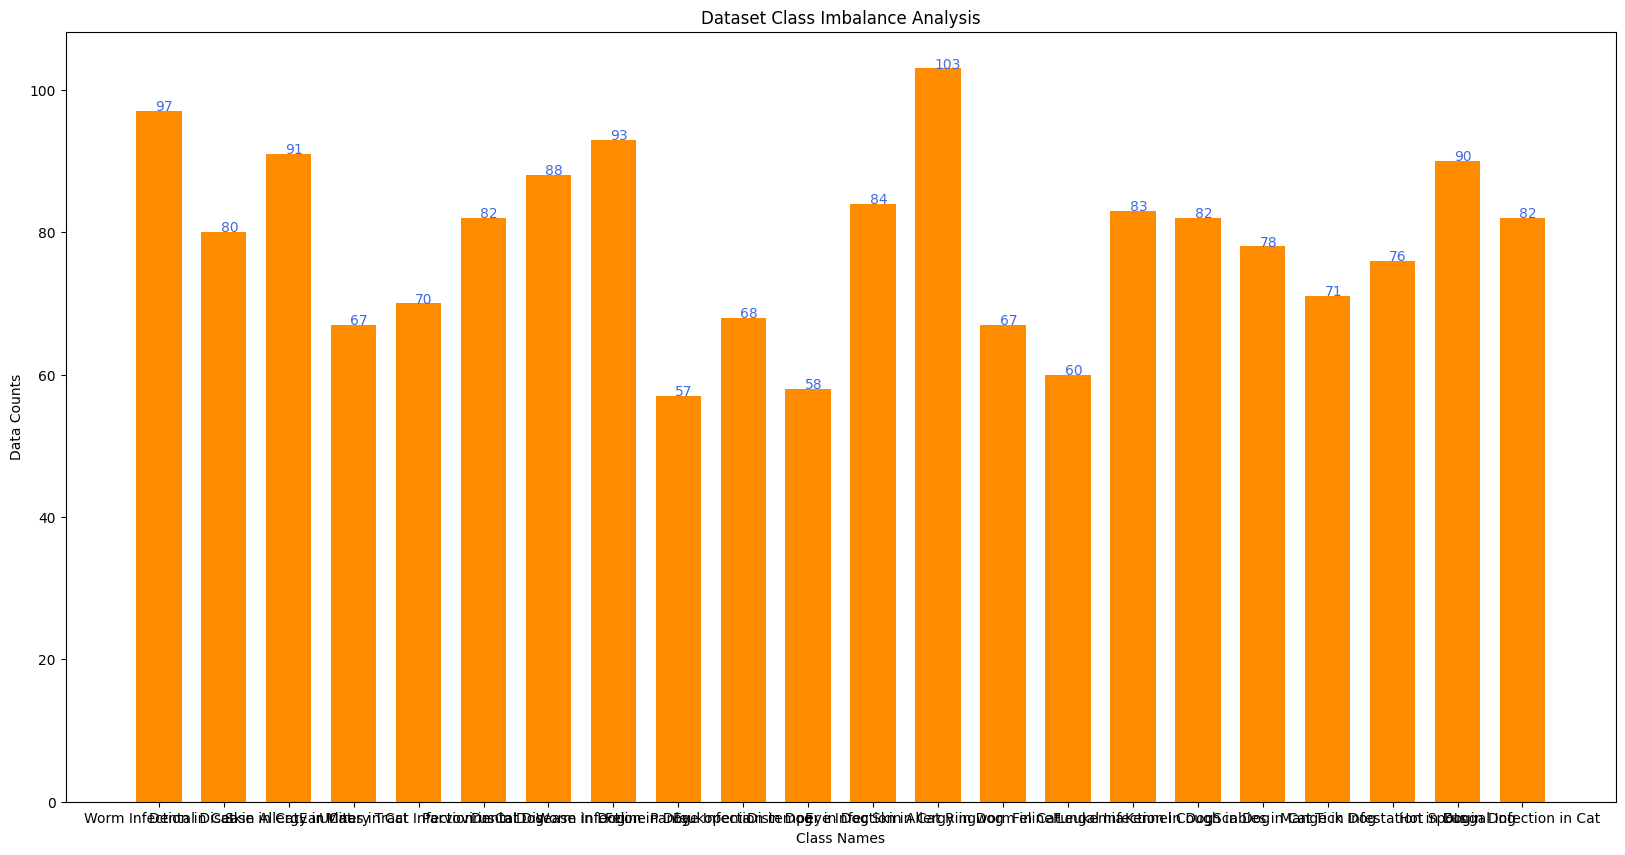

In [ ]:
from matplotlib import pyplot as plt

class Visualization:

  def __init__(self, vis_datas, n_ims, rows, cmap = None, cls_names = None, cls_counts = None, t_type = "rgb"):

    self.n_ims, self.rows = n_ims, rows
    self.t_type, self.cmap = t_type, cmap
    self.cls_names = cls_names

    data_names = ["train", "val", "test"]
    self.vis_datas = {data_names[i]: vis_datas[i] for i in range(len(vis_datas))}
    if isinstance(cls_counts, list): self.analysis_datas = {data_names[i]: cls_counts[i] for i in range(len(cls_counts))}
    else: self.analysis_datas = {"all": cls_counts}


  def tn2np(self, t):

    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [1/0.229, 1/0.224, 1/0.225]), T.Normalize(mean = [-0.485, -0.456, -0.406], std = [1., 1., 1.])])

    invTrans = gray_tfs if self.t_type == "gray" else rgb_tfs

    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if self.t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)

  def plot(self, rows, cols, count, im, title = "Original Image"):

    plt.subplot(rows, cols, count)
    plt.imshow(self.tn2np(im))
    plt.axis("off"); plt.title(title)


    return count + 1

  def vis(self, data, save_name):

    print(f"{save_name.upper()} Data Visualization is in process...\n")
    assert self.cmap in ["rgb", "gray"], "Please choose rgb or gray cmap"
    if self.cmap == "rgb": cmap = "viridis"
    cols = self.n_ims // self.rows; count = 1

    plt.figure(figsize = (25, 20))

    indices = [np.random.randint(low = 0, high = len(data) - 1) for _ in range(self.n_ims)]

    for idx, index in enumerate(indices):

      if count == self.n_ims + 1: break

      meta_data = data[index]
      qry_im, pos_im, neg_im, qry_lbl, neg_lbl = meta_data["qry_im"], meta_data["pos_im"], meta_data["neg_im"], meta_data["qry_gt"], meta_data["neg_gt"]


      # First Plot
      count = self.plot(self.rows, cols, count, im = qry_im, title = f"Query Image \n Class -> {self.cls_names[qry_lbl]}" )

      # Second Plot
      count = self.plot(self.rows, cols, count, im = pos_im, title = f"Positive Image \n Class -> {self.cls_names[qry_lbl]}")

      # Third Plot
      count = self.plot(self.rows, cols, count, im = neg_im, title = f"Negative Image -> {self.cls_names[neg_lbl]}")

    plt.show()


  def plot_pie_chart(self, cls_counts):
    print("Generating pie chart...\n")
    labels = list(cls_counts.keys())
    sizes = list(cls_counts.values())
    explode = [0.1] * len(labels) # To highlight all slices equally


    plt.figure(figsize = (8, 8))
    plt.pie(sizes, explode = explode, labels = labels, autopct = "%1.1f%%", startangle = 140, colors = plt.cm.tab20.colors)
    plt.title("Class Distribution")
    plt.axis("equal")
    plt.show()


  def data_analysis(self, cls_counts, save_name):

    print("Data analysis is in progress...\n")

    width, text_width, text_height = 0.7, 0.05, 2
    cls_names = list(cls_counts.keys());
    counts = list(cls_counts.values())

    _, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "darkorange")
    ax.set_xlabel("Class Names", color = "black")
    ax.set_xticklabels(cls_names)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "black")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_width, str(v), color = "royalblue")


  def visualization(self): [self.vis(data.dataset, save_name) for (save_name, data) in self.vis_datas.items()]

  def pie_chart(self):  [self.plot_pie_chart(data) for data in self.analysis_datas.values()]


  def analysis(self):
    [self.data_analysis(data, save_name) for (save_name, data) in self.analysis_datas.items()]

vis = Visualization(vis_datas = [tr_dl, val_dl, ts_dl], n_ims = 18, rows = 6, cmap = "rgb", cls_names = list(classes.keys()), cls_counts = cls_counts)
vis.analysis()


Generating pie chart...



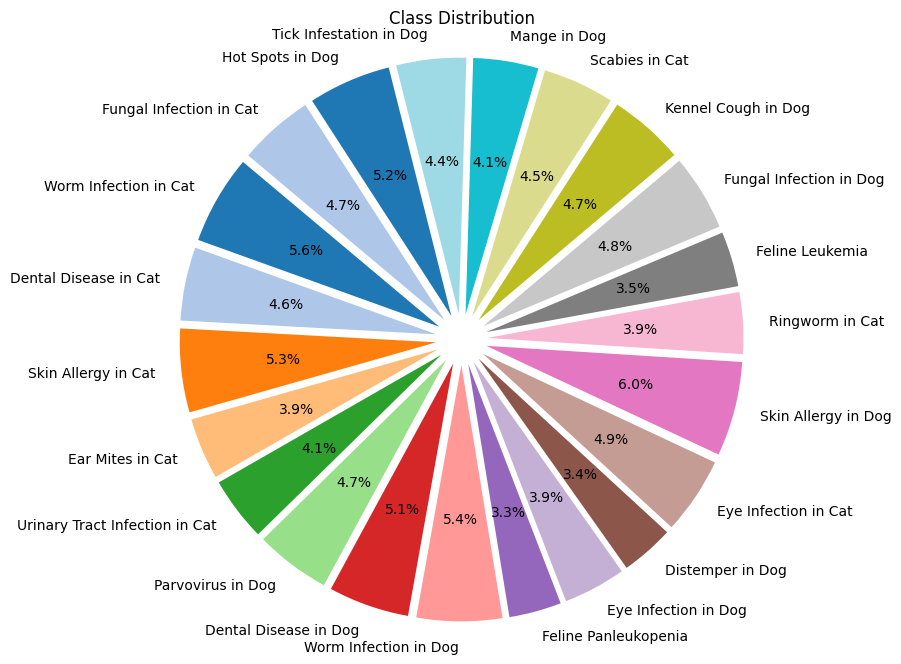

In [ ]:
vis.pie_chart()

TRAIN Data Visualization is in process...



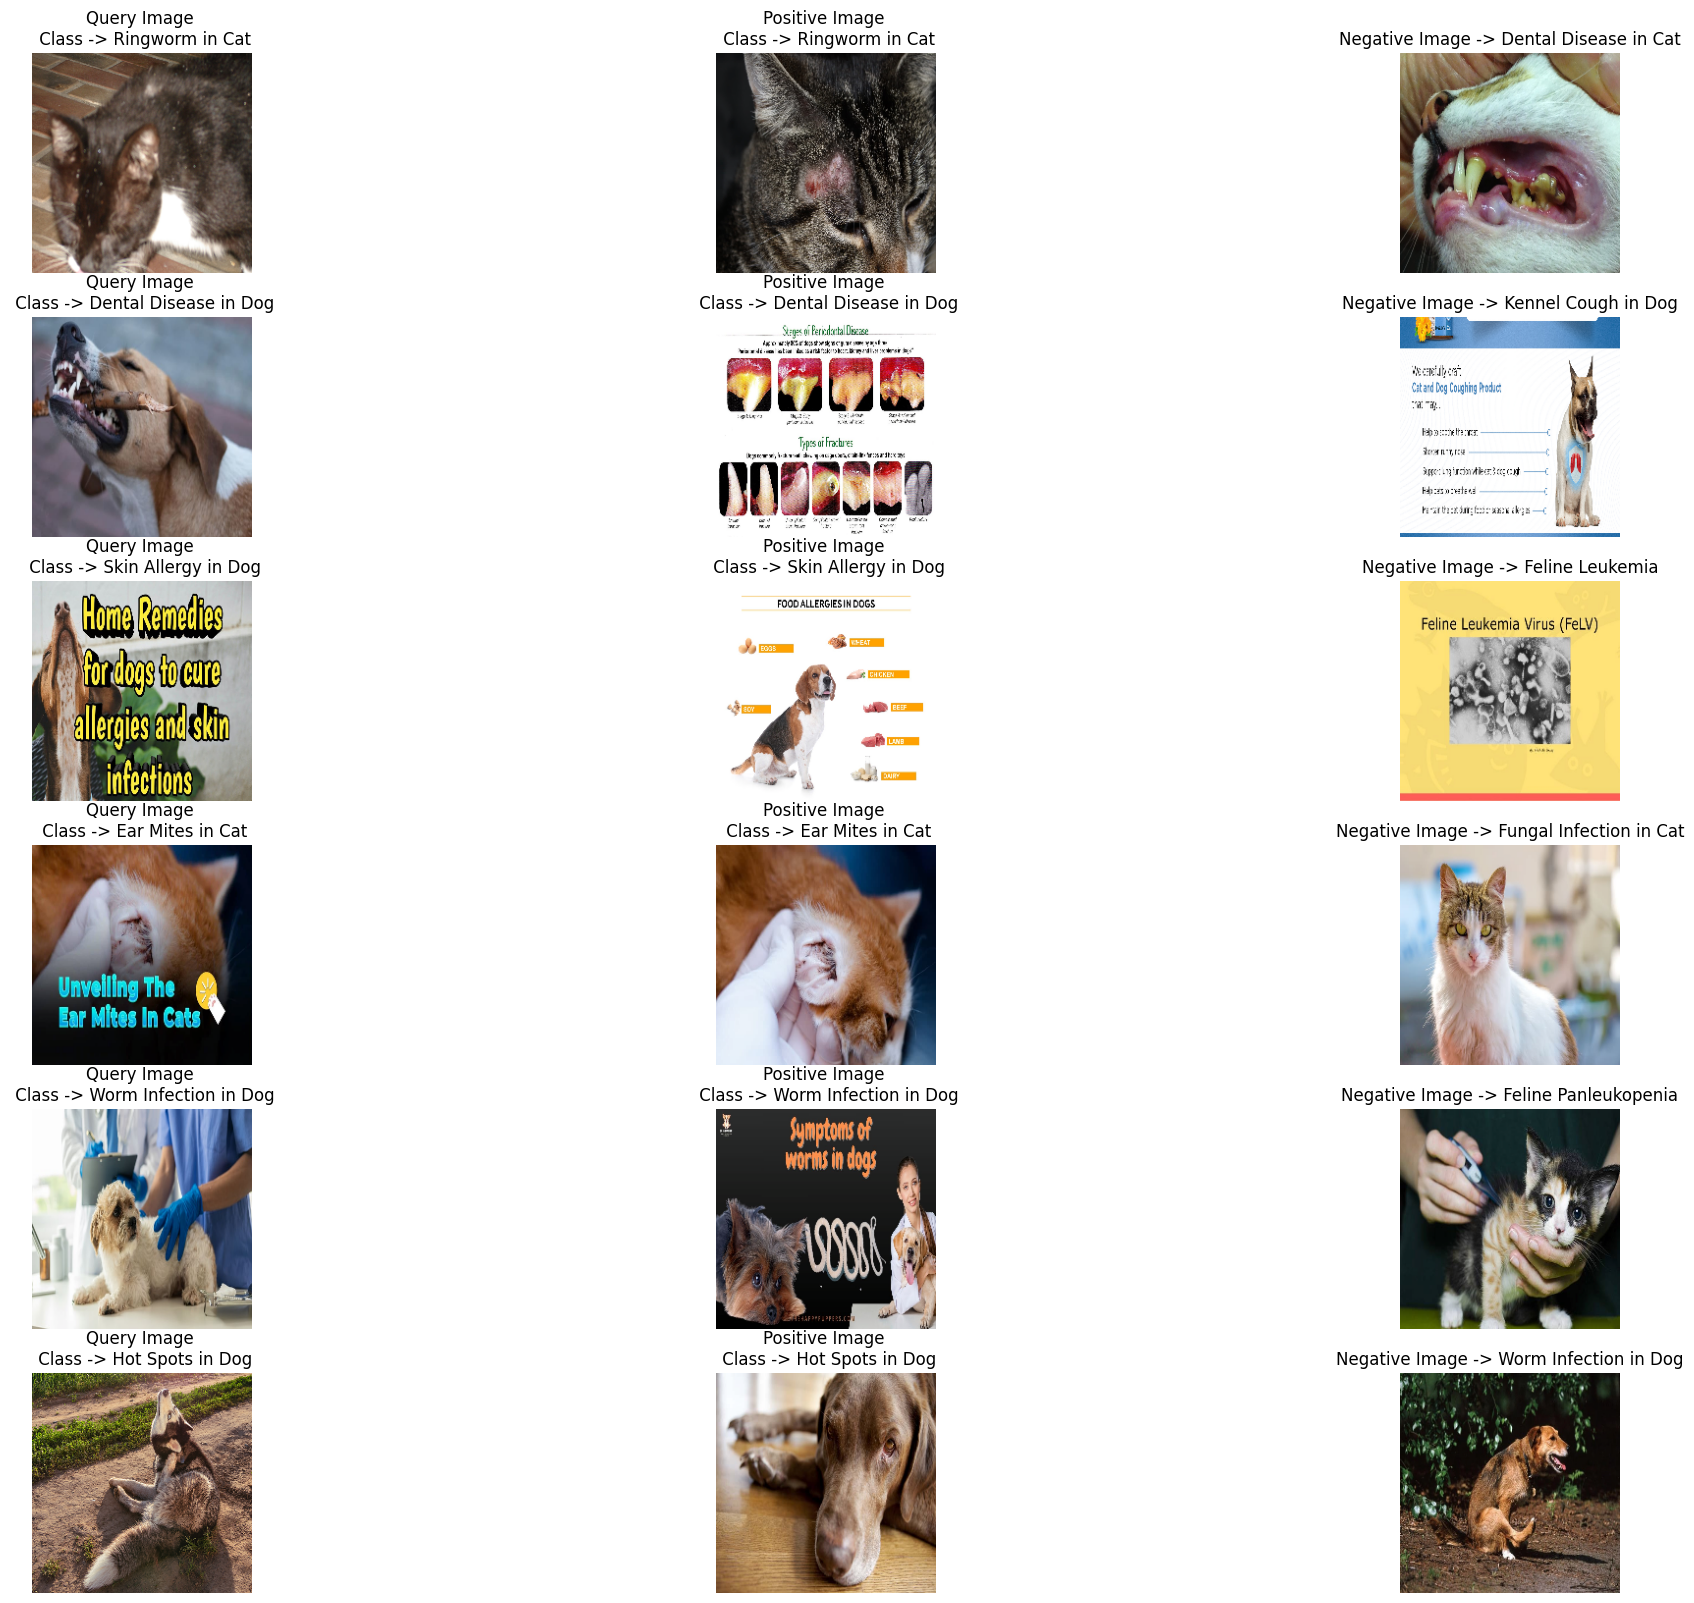

VAL Data Visualization is in process...



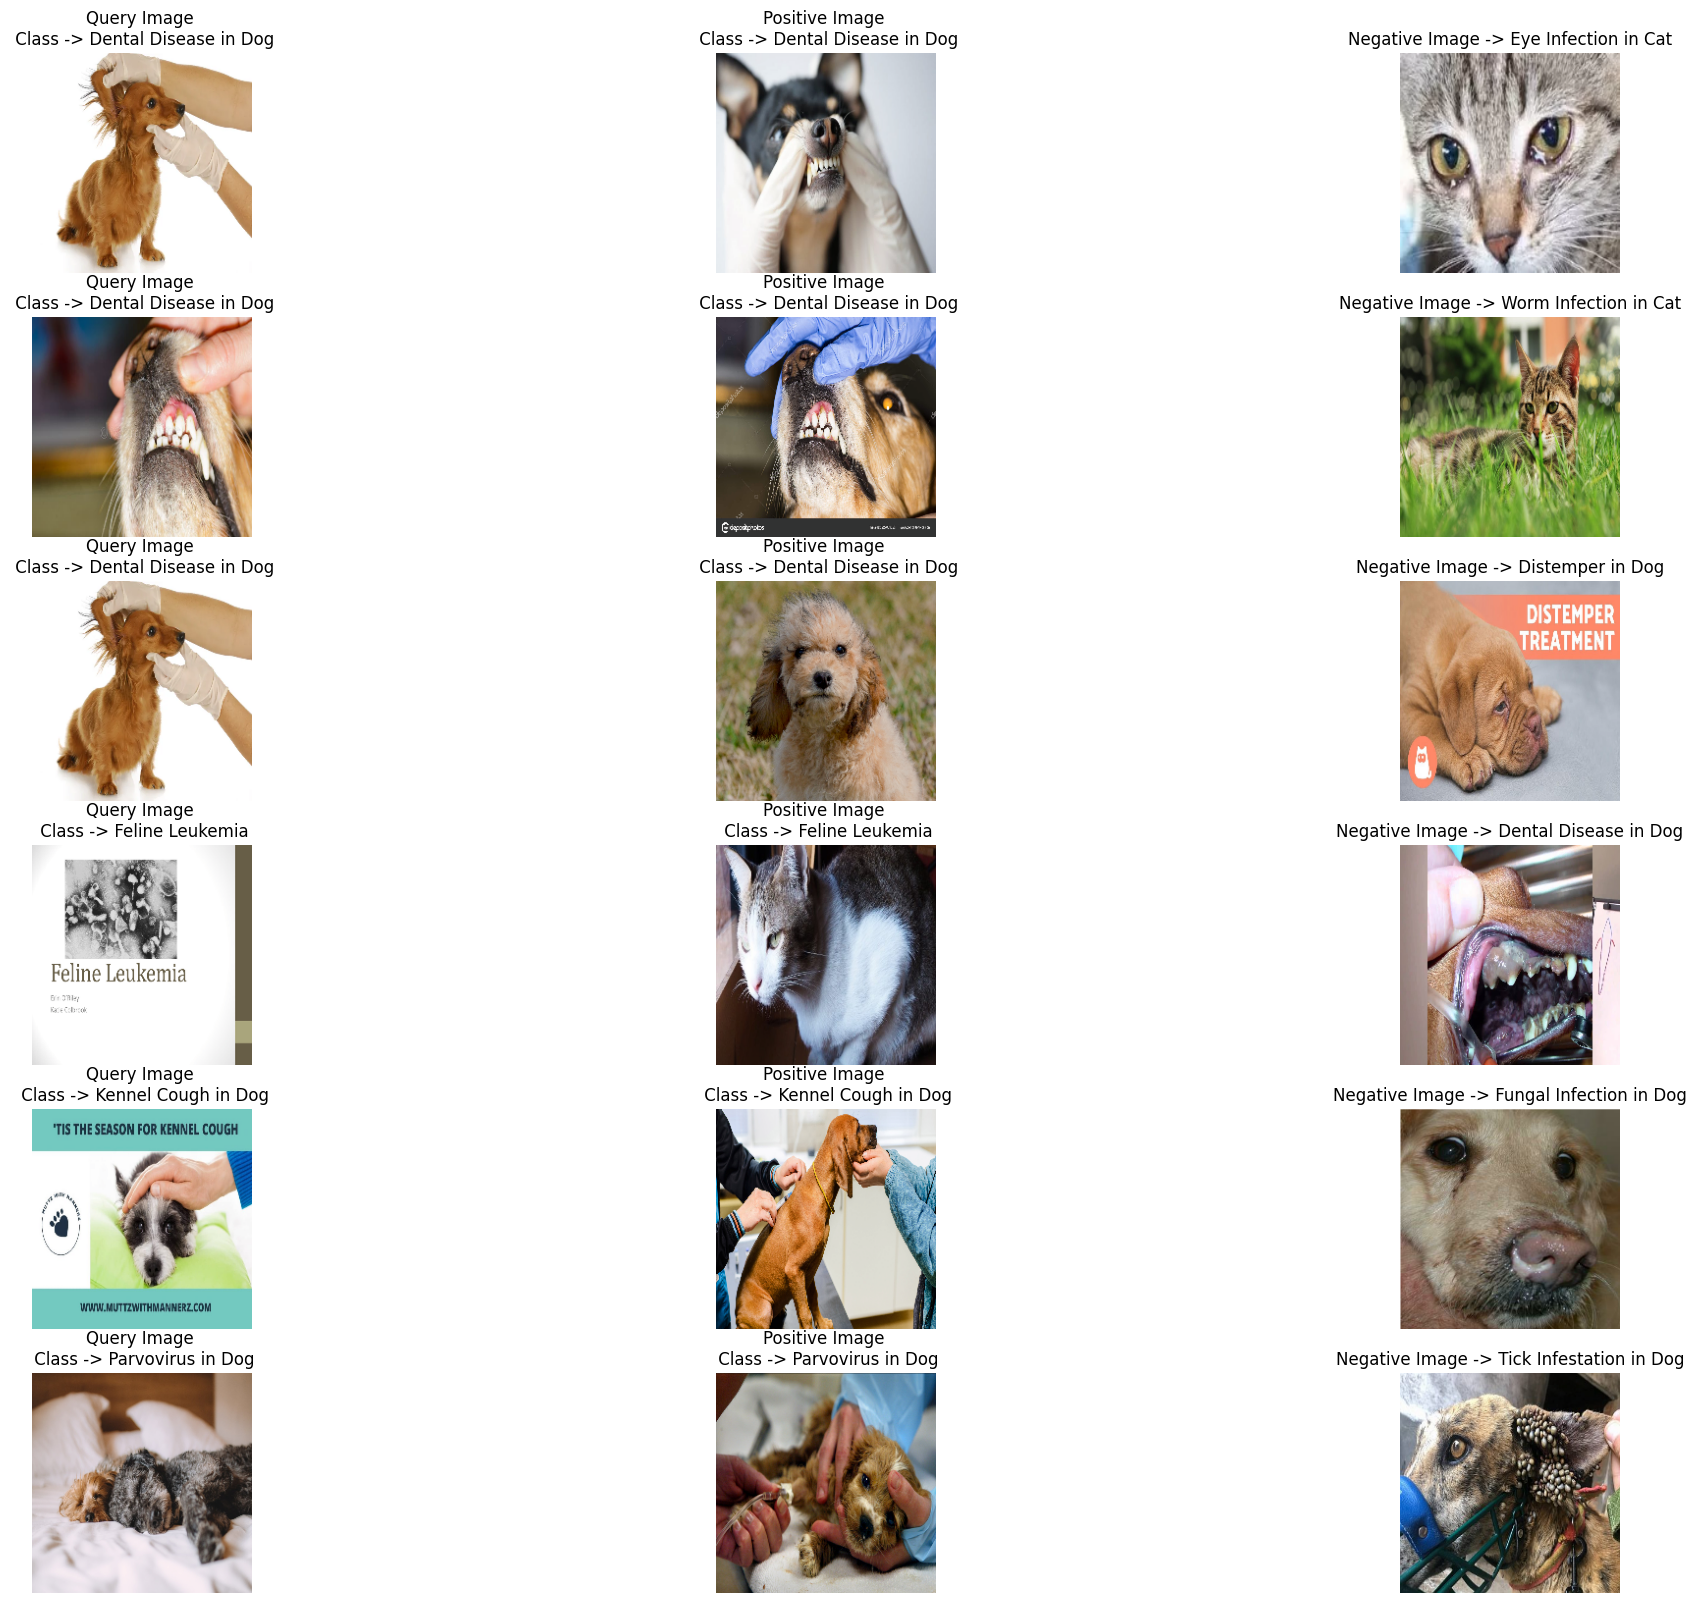

TEST Data Visualization is in process...



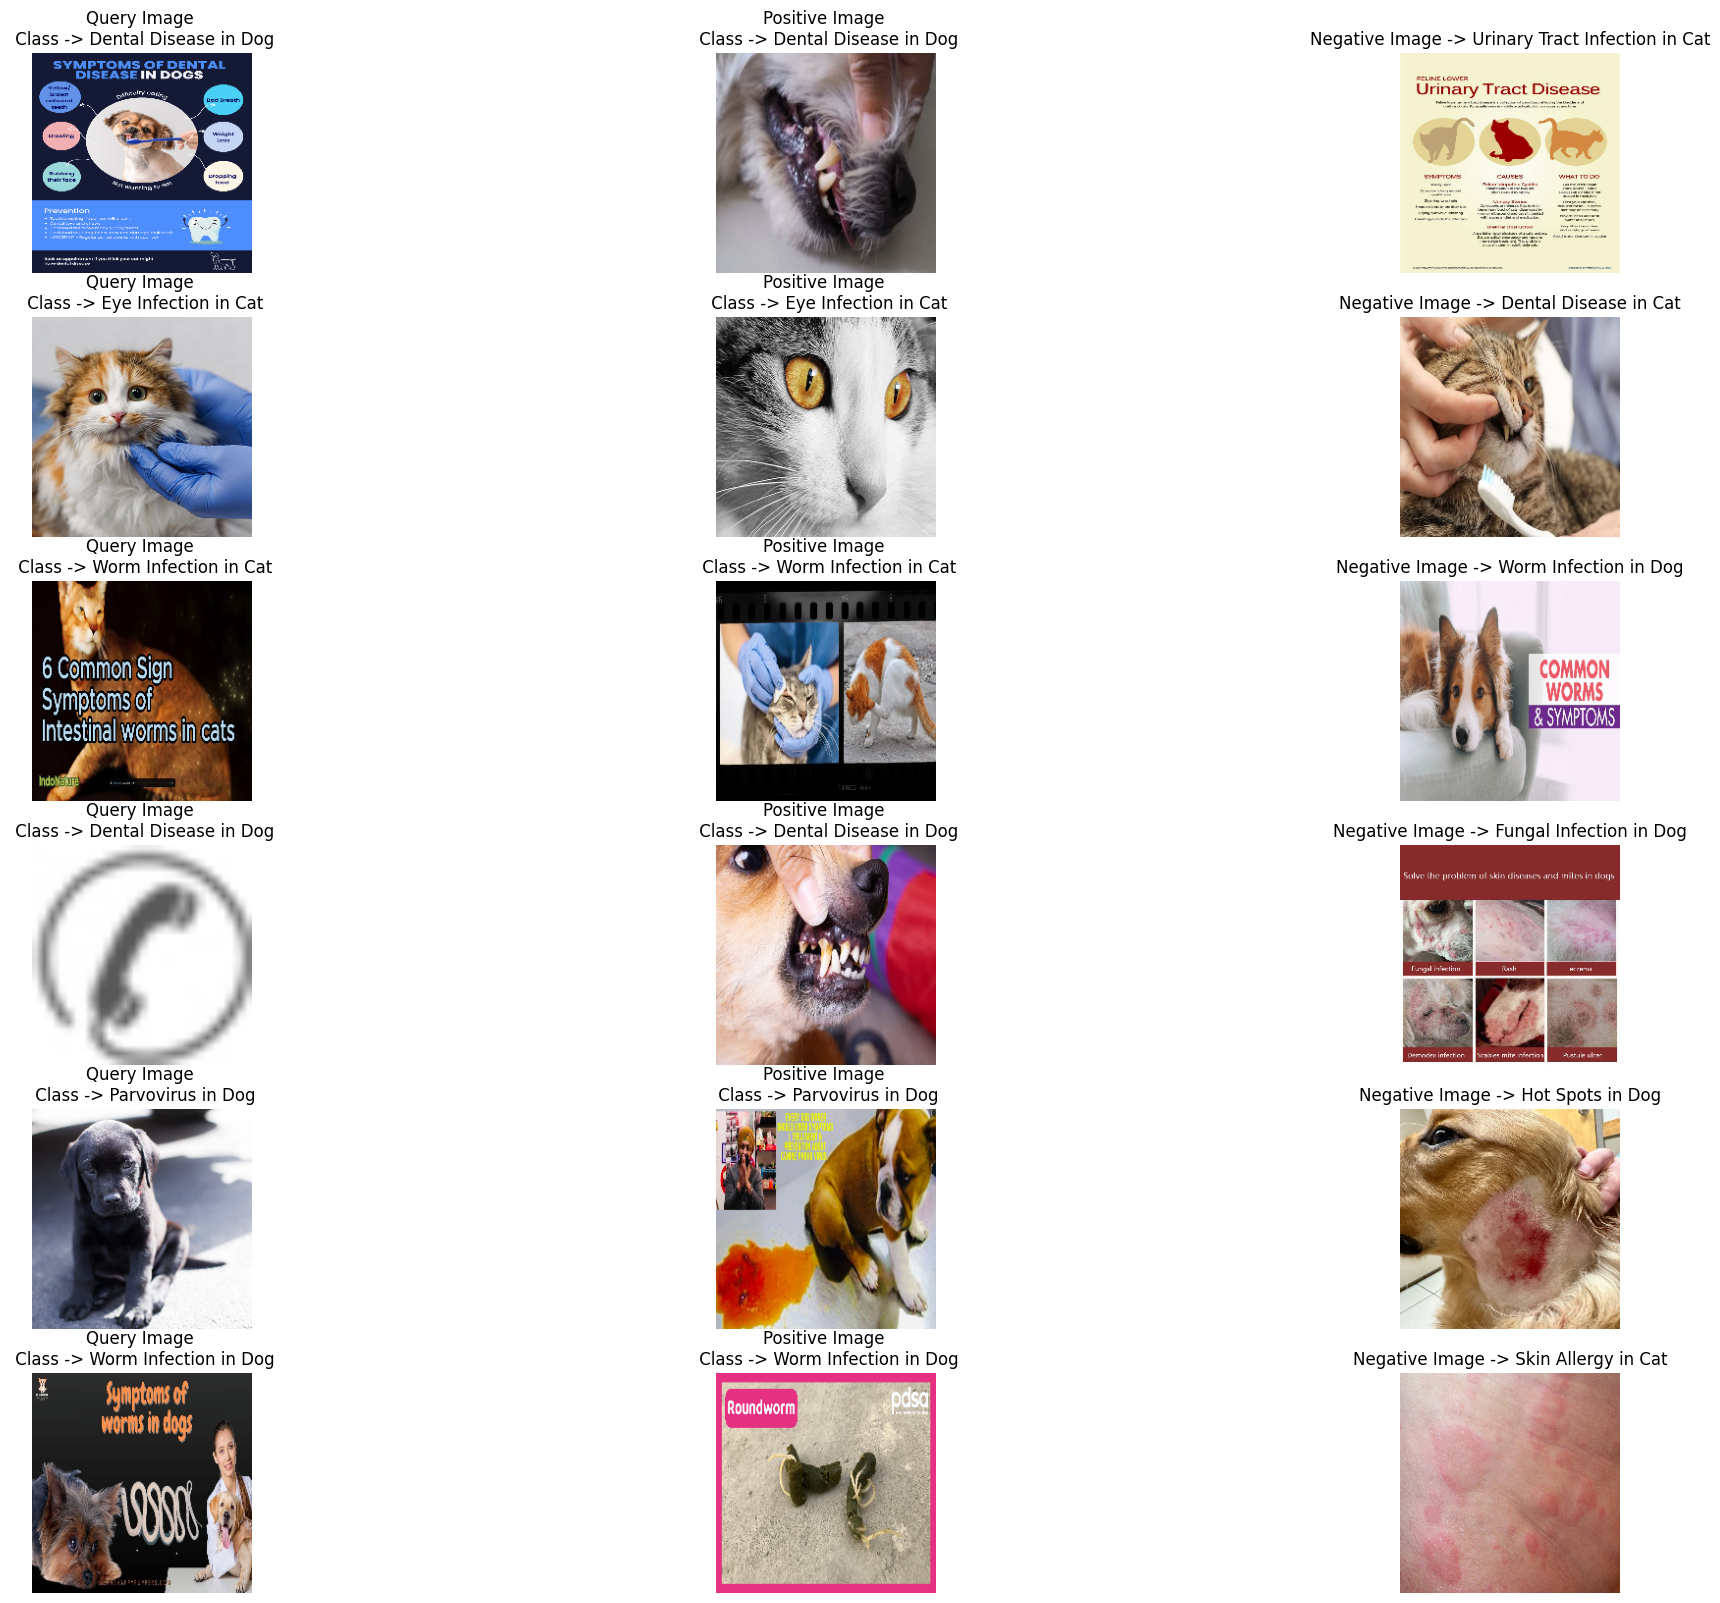

In [ ]:
vis.visualization()

# ✨  Custom AI Model: Train and Validation ✨

In [ ]:
import torch.nn.functional as F
import torch
from torch.nn import *

class CustomModel(Module):

  def __init__(self, num_classes):
     super(CustomModel, self).__init__()

     # Conv block - 1
     self.conv1 = Sequential(
         Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
         ReLU(),
         BatchNorm2d(32),
         MaxPool2d(kernel_size = 2, stride = 2)

     )

     # Conv block - 2
     self.conv2 = Sequential(
         Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
         ReLU(),
         BatchNorm2d(64),
         MaxPool2d(kernel_size = 2, stride = 2)
     )

     # Conv block - 3
     self.conv3 = Sequential(
         Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
         ReLU(),
         BatchNorm2d(128),
         MaxPool2d(kernel_size = 2, stride = 2)
     )

     # Conv block - 4
     self.conv4 = Sequential(
         Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
         ReLU(),
         BatchNorm2d(256),
         MaxPool2d(kernel_size = 2, stride = 2)
     )


     self.fc1 = Linear(256 * 14 * 14, 128)
     self.fc2 = Linear(128, len(cls_counts))


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    return x





In [ ]:
model = CustomModel(len(cls_counts))
print(model)

CustomModel(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU

In [ ]:
len(cls_counts)

22

In [ ]:
import warnings
from PIL import Image

# Suppress PIL warnings
warnings.filterwarnings("ignore", category=UserWarning, module="PIL")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
epochs = 15

tr_loss = []
tr_acc = []
vl_loss = []
vl_acc = []

for epoch in range(epochs):
    tr_epoch_acc = 0
    tr_epoch_loss = 0
    vl_epoch_acc = 0
    vl_epoch_loss = 0

    # Training
    model.train()
    for idx, batch in enumerate(tr_dl):
        # Extract query images and labels from the dictionary
        rasmlar = batch["qry_im"]  # Query images
        javoblar = batch["qry_gt"]  # Query ground truth labels

        rasmlar = rasmlar.to(device)
        javoblar = javoblar.to(device)

        xom_bashoratlar = model(rasmlar)
        bashoratlar = torch.argmax(xom_bashoratlar, dim = 1)

        loss = loss_fn(xom_bashoratlar, javoblar)
        tr_epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_acc = (bashoratlar == javoblar).sum().item()
        tr_epoch_acc += batch_acc

    # Calculating the averages for training
    avg_tr_loss = tr_epoch_loss / len(tr_dl)
    avg_tr_acc = tr_epoch_acc / len(tr_dl.dataset)

    print(f"{epoch + 1}-epochdagi train loss --> {avg_tr_loss:.3f}")
    print(f"{epoch + 1}-epochdagi train accuracy --> {avg_tr_acc:.3f}")

    # Validation
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_dl):
            # Extract query images and labels from the dictionary
            rasmlar = batch["qry_im"]  # Query images
            javoblar = batch["qry_gt"]  # Query ground truth labels

            rasmlar = rasmlar.to(device)
            javoblar = javoblar.to(device)

            xom_bashoratlar = model(rasmlar)
            bashoratlar = torch.argmax(xom_bashoratlar, dim = 1)
            loss = loss_fn(xom_bashoratlar, javoblar)
            vl_epoch_loss += loss.item()

            batch_acc = (bashoratlar == javoblar).sum().item()
            vl_epoch_acc += batch_acc

    # Calculating the averages
    avg_vl_loss = vl_epoch_loss / len(val_dl)
    avg_vl_acc = vl_epoch_acc / len(val_dl.dataset)

    print(f"{epoch + 1}-epochdagi validation loss --> {avg_vl_loss:.3f}")
    print(f"{epoch + 1}-epochdagi validation accuracy --> {avg_vl_acc:.3f}\n {'~'*86}\n")

    # Appending the averages to lists after each epoch
    tr_loss.append(avg_tr_loss)
    tr_acc.append(avg_tr_acc)
    vl_loss.append(avg_vl_loss)
    vl_acc.append(avg_vl_acc)

1-epochdagi train loss --> 3.022
1-epochdagi train accuracy --> 0.125
1-epochdagi validation loss --> 3.014
1-epochdagi validation accuracy --> 0.151
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

2-epochdagi train loss --> 2.104
2-epochdagi train accuracy --> 0.405
2-epochdagi validation loss --> 3.246
2-epochdagi validation accuracy --> 0.151
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

3-epochdagi train loss --> 1.028
3-epochdagi train accuracy --> 0.739
3-epochdagi validation loss --> 3.012
3-epochdagi validation accuracy --> 0.302
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

4-epochdagi train loss --> 0.287
4-epochdagi train accuracy --> 0.961
4-epochdagi validation loss --> 3.127
4-epochdagi validation accuracy --> 0.314
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

5-epochdagi train loss --> 0.152
5-epochdagi

# 🛠️🧠  Fine tuning with RexNet-150 🛠️🧠

In [ ]:
! pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 133.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unins

In [ ]:
import os, timm, torch, datetime
from torchmetrics.classification import MulticlassStatScores, MulticlassF1Score
from tqdm import tqdm
from time import time

class TrainValidation:

    def __init__(self, model_name, tr_dl, val_dl, classes, device, lr, save_dir,
                 run_name, data_name, epochs, project_name, bs, patience = 5, dev_mode = False):

        self.model_name, self.classes, self.device      = model_name, classes, device
        self.data_name, self.lr, self.save_dir, self.bs = data_name, lr, save_dir, bs
        self.tr_dl, self.val_dl, self.patience, self.dm = tr_dl, val_dl, patience, dev_mode
        self.run_name, self.epochs, self.project_name   = run_name, epochs, project_name
        self.run()

    def init_model(self): self.model = timm.create_model(self.model_name, pretrained = True, num_classes = len(self.classes))

    def init_lists(self): self.tr_losses, self.val_losses, self.tr_sens, self.val_senss, self.tr_specs, self.val_specs, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s, self.tr_times, self.vl_times = [], [], [], [], [], [], [], [], [], [], [], []

    def train_setup(self):

        self.best_loss, self.threshold, self.not_improved = float(torch.inf), 0.01, 0
        self.stop_train, self.tr_len, self.val_len        = False, len(self.tr_dl), len(self.val_dl)
        self.cs_lbls = {"cos_pos": torch.tensor(1.).unsqueeze(0), "cos_neg": torch.tensor(-1.).unsqueeze(0)}
        self.ckpt_path = f"{self.save_dir}/{self.data_name}_{self.run_name}_{self.model_name}_best_model.pth"
        run_name = f"{self.run_name}_{self.model_name}_bs_{self.bs}"

        str_time = str(datetime.datetime.now()).split(".")[0]

        self.model.to(self.device).eval()
        self.ce_loss_fn   = torch.nn.CrossEntropyLoss()
        self.cs_loss_fn   = torch.nn.CosineEmbeddingLoss(margin = 0.3)
        self.optimizer   = torch.optim.Adam(params = self.model.parameters(), lr = self.lr)
        self.f1_score    = MulticlassF1Score(num_classes = len(self.classes), average = "micro").to(self.device)
        self.stat_scores = MulticlassStatScores(num_classes = len(self.classes), average = "micro").to(self.device)

    def makedirs(self, path): os.makedirs(path, exist_ok = True)

    def get_fms(self, fms):

        """
        s
        This function gets feature map with size (bs, fm_shape, 7, 7)
        applies average pooling and returns feature map with shape (bs, fm_shape).

        Parameter:

            fm - feature map, tensor.

        Output:

            fm - reshaped feature map, tensor.

        """

        pool = torch.nn.AvgPool2d((fms[0].shape[2], fms[0].shape[3]))

        return [torch.reshape(pool(fm), (-1, fm.shape[1])) for fm in fms]

    def get_logits(self, ims): return [self.model.forward_features(im) for im in ims]

    def get_preds(self, fts): return [self.model.forward_head(ft) for ft in fts]

    def get_cs_loss(self, qry_fms, pos_fms, neg_fms): return self.cs_loss_fn(qry_fms, pos_fms, self.cs_lbls["cos_pos"].to(self.device)) + self.cs_loss_fn(qry_fms, neg_fms, self.cs_lbls["cos_neg"].to(self.device))

    def get_ce_loss(self, qry_preds, pos_preds, qry_lbls): return self.ce_loss_fn(qry_preds, qry_lbls) + self.ce_loss_fn(pos_preds, qry_lbls)

    def get_preds_loss(self, qry_ims, pos_ims, neg_ims, qry_lbls):

        # Get logits
        qry_logits, pos_logits, neg_logits = self.get_logits([qry_ims, pos_ims, neg_ims])
        qry_preds, pos_preds = self.get_preds([qry_logits, pos_logits])

        # Contrastive loss
        qry_fms, pos_fms, neg_fms = self.get_fms([qry_logits, pos_logits, neg_logits])
        cs_loss = self.get_cs_loss(qry_fms, pos_fms, neg_fms)

        # Cross entropy loss
        ce_loss = self.get_ce_loss(qry_preds, pos_preds, qry_lbls)

        # Final loss
        loss = cs_loss + ce_loss

        return torch.argmax(qry_preds, dim = 1), loss

    def eval_train_batch(self, preds, gts, loss):

        self.epoch_acc    += (preds == gts).sum().item()
        self.epoch_loss   += loss.item()
        self.epoch_f1     += self.f1_score(preds, gts)
        tp, fp, tn, fn, _  = self.stat_scores(preds, gts)
        self.spec         += tn / (tn + fp)
        self.sens         += tp / (tp + fn)

    def eval_valid_batch(self, preds, gts, loss):

        self.val_epoch_loss   += loss.item()
        self.val_epoch_acc    += (preds == gts).sum().item()
        self.val_epoch_f1     +=  self.f1_score(preds, gts)
        tp, fp, tn, fn, _      = self.stat_scores(preds, gts)
        self.val_spec         += tn / (tn + fp)
        self.val_sens         += tp / (tp + fn)

    def to_device(self, batch): return batch["qry_im"].to(self.device), batch["pos_im"].to(self.device), batch["neg_im"].to(self.device), batch["qry_gt"].to(self.device)

    def train_one_epoch(self, epoch):

        self.model.train()
        self.epoch_loss, self.epoch_acc, self.epoch_f1, self.loss, self.sens, self.spec = 0, 0, 0, 0, 0, 0

        tr_start = time();
        for idx, batch in tqdm(enumerate(self.tr_dl)):

            if self.dm:
                if idx == 1: break

            qry_ims, pos_ims, neg_ims, qry_im_lbls = self.to_device(batch)

            qry_preds, loss = self.get_preds_loss(qry_ims, pos_ims, neg_ims, qry_im_lbls)
            self.eval_train_batch(qry_preds, qry_im_lbls, loss)
            self.optimizer.zero_grad(); loss.backward(); self.optimizer.step()

        tr_time = time() - tr_start; self.tr_times.append(tr_time)
        tr_loss_to_track = self.epoch_loss / self.tr_len
        tr_sens_to_track = self.sens / self.tr_len
        tr_spec_to_track = self.spec / self.tr_len
        tr_acc_to_track  = self.epoch_acc  / len(self.tr_dl.dataset)
        tr_f1_to_track   = self.epoch_f1   / self.tr_len
        self.tr_losses.append(tr_loss_to_track); self.tr_accs.append(tr_acc_to_track); self.tr_f1s.append(tr_f1_to_track); self.tr_sens.append(tr_sens_to_track); self.tr_specs.append(tr_spec_to_track)

        print("\n~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~")
        print(f"\n{epoch + 1}-epoch train process is completed!\n")
        print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch train spec          -> {tr_spec_to_track:.3f}")
        print(f"{epoch + 1}-epoch train sens          -> {tr_sens_to_track:.3f}")
        print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    def eval_one_epoch(self, epoch):

        self.val_epoch_loss, self.val_epoch_acc, self.val_epoch_f1, self.val_sens, self.val_spec = 0, 0, 0, 0, 0
        self.model.eval()
        with torch.no_grad():
            vl_start = time()
            for idx, batch in enumerate(self.val_dl):

                if self.dm:
                    if idx == 1: break

                qry_ims, pos_ims, neg_ims, qry_im_lbls = self.to_device(batch)

                qry_preds, loss = self.get_preds_loss(qry_ims, pos_ims, neg_ims, qry_im_lbls)
                self.eval_valid_batch(qry_preds, qry_im_lbls, loss)

            vl_time = time() - vl_start; self.vl_times.append(vl_time)
            val_loss_to_track = self.val_epoch_loss  / self.val_len
            val_sens_to_track = self.val_sens / self.val_len
            val_spec_to_track = self.val_spec / self.val_len
            val_acc_to_track  = self.val_epoch_acc   / len(self.val_dl.dataset)
            val_f1_to_track   = self.val_epoch_f1    / self.val_len
            self.val_losses.append(val_loss_to_track); self.val_accs.append(val_acc_to_track); self.val_f1s.append(val_f1_to_track); self.val_senss.append(val_sens_to_track); self.val_specs.append(val_spec_to_track)

            print(f"\n{epoch + 1}-epoch validation process is completed!\n")
            print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
            print(f"{epoch + 1}-epoch validation spec     -> {val_spec_to_track:.3f}")
            print(f"{epoch + 1}-epoch validation sens     -> {val_sens_to_track:.3f}")
            print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
            print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

            print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        return val_loss_to_track

    def save_best_model(self): torch.save(self.model.state_dict(), self.ckpt_path); print("Pretrained weights of the model with lowest loss are successfully saved!")

    def epoch_summary(self, metric):

        if (metric + self.threshold) < self.best_loss:

            print(f"\nValidation loss is decreased from {self.best_loss:.5f} to {metric:.5f}")
            print("Saving the best model with the lowest loss value...\n")
            self.best_loss = metric
            self.save_best_model()

        else:

            self.not_improved += 1
            print(f"\nValidation loss is not significantly decreased from {self.best_loss:.5f}. The current epoch loss is {metric:.5f}.")
            print(f"Validation loss value did not decrease for {self.not_improved} epochs")
            if self.not_improved == self.patience:
                print(f"Stop training since loss value did not decrease for {self.patience} epochs.")
                self.stop_train = True

    def train(self):

        print("Start training...")
        for epoch in range(self.epochs):
            if self.dm:
                if epoch == 1: break
            self.train_one_epoch(epoch); loss = self.eval_one_epoch(epoch)
            self.epoch_summary(loss)
            if self.stop_train: break

    def get_stats(self): return [self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s, self.tr_specs, self.val_specs, self.tr_sens, self.val_senss, self.tr_times, self.vl_times]

    def run(self): self.makedirs(self.save_dir); self.init_lists(); self.init_model(); self.train_setup(); self.train()

project_name, run_name, model_name   = "kaggle", "triplet", "rexnet_150"
save_dir, data_name, epochs, device  = "saved_models", "pet", 50, "cuda" if torch.cuda.is_available() else "cpu"

results = TrainValidation(model_name = model_name, tr_dl = tr_dl, val_dl = val_dl,
                          classes = classes, device = device, lr = 3e-4, save_dir = save_dir,
                          data_name = data_name, project_name = project_name, bs = bs, run_name = run_name,
                          epochs = epochs, patience = 3, dev_mode = False).get_stats()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

Start training...


98it [00:45,  2.18it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

1-epoch train process is completed!

1-epoch train loss          -> 4.523
1-epoch train spec          -> 0.973
1-epoch train sens          -> 0.437
1-epoch train accuracy      -> 0.441
1-epoch train f1-score      -> 0.437



1-epoch validation process is completed!

1-epoch validation loss     -> 2.364
1-epoch validation spec     -> 0.985
1-epoch validation sens     -> 0.694
1-epoch validation accuracy -> 0.698
1-epoch validation f1-score -> 0.694

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from inf to 2.36446
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


98it [00:45,  2.16it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

2-epoch train process is completed!

2-epoch train loss          -> 1.623
2-epoch train spec          -> 0.993
2-epoch train sens          -> 0.862
2-epoch train accuracy      -> 0.861
2-epoch train f1-score      -> 0.862



2-epoch validation process is completed!

2-epoch validation loss     -> 1.486
2-epoch validation spec     -> 0.990
2-epoch validation sens     -> 0.781
2-epoch validation accuracy -> 0.814
2-epoch validation f1-score -> 0.781

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 2.36446 to 1.48591
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


98it [00:42,  2.30it/s]



~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

3-epoch train process is completed!

3-epoch train loss          -> 1.126
3-epoch train spec          -> 0.998
3-epoch train sens          -> 0.953
3-epoch train accuracy      -> 0.953
3-epoch train f1-score      -> 0.953

3-epoch validation process is completed!

3-epoch validation loss     -> 0.984
3-epoch validation spec     -> 0.997
3-epoch validation sens     -> 0.931
3-epoch validation accuracy -> 0.942
3-epoch validation f1-score -> 0.931

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 1.48591 to 0.98423
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


98it [00:44,  2.21it/s]



~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

4-epoch train process is completed!

4-epoch train loss          -> 1.038
4-epoch train spec          -> 0.998
4-epoch train sens          -> 0.952
4-epoch train accuracy      -> 0.961
4-epoch train f1-score      -> 0.952

4-epoch validation process is completed!

4-epoch validation loss     -> 0.920
4-epoch validation spec     -> 0.997
4-epoch validation sens     -> 0.938
4-epoch validation accuracy -> 0.930
4-epoch validation f1-score -> 0.938

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 0.98423 to 0.92035
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


98it [00:44,  2.20it/s]



~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

5-epoch train process is completed!

5-epoch train loss          -> 1.006
5-epoch train spec          -> 0.998
5-epoch train sens          -> 0.949
5-epoch train accuracy      -> 0.953
5-epoch train f1-score      -> 0.949

5-epoch validation process is completed!

5-epoch validation loss     -> 0.843
5-epoch validation spec     -> 0.998
5-epoch validation sens     -> 0.948
5-epoch validation accuracy -> 0.942
5-epoch validation f1-score -> 0.948

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 0.92035 to 0.84286
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


98it [00:46,  2.12it/s]



~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

6-epoch train process is completed!

6-epoch train loss          -> 0.967
6-epoch train spec          -> 0.998
6-epoch train sens          -> 0.959
6-epoch train accuracy      -> 0.963
6-epoch train f1-score      -> 0.959

6-epoch validation process is completed!

6-epoch validation loss     -> 0.847
6-epoch validation spec     -> 0.997
6-epoch validation sens     -> 0.938
6-epoch validation accuracy -> 0.930
6-epoch validation f1-score -> 0.938

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is not significantly decreased from 0.84286. The current epoch loss is 0.84748.
Validation loss value did not decrease for 1 epochs


98it [00:45,  2.16it/s]



~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

7-epoch train process is completed!

7-epoch train loss          -> 0.847
7-epoch train spec          -> 0.998
7-epoch train sens          -> 0.967
7-epoch train accuracy      -> 0.972
7-epoch train f1-score      -> 0.967

7-epoch validation process is completed!

7-epoch validation loss     -> 0.745
7-epoch validation spec     -> 0.999
7-epoch validation sens     -> 0.969
7-epoch validation accuracy -> 0.965
7-epoch validation f1-score -> 0.969

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 0.84286 to 0.74481
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


98it [00:45,  2.14it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

8-epoch train process is completed!

8-epoch train loss          -> 0.885
8-epoch train spec          -> 0.998
8-epoch train sens          -> 0.955
8-epoch train accuracy      -> 0.964
8-epoch train f1-score      -> 0.955



8-epoch validation process is completed!

8-epoch validation loss     -> 0.772
8-epoch validation spec     -> 0.999
8-epoch validation sens     -> 0.969
8-epoch validation accuracy -> 0.965
8-epoch validation f1-score -> 0.969

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is not significantly decreased from 0.74481. The current epoch loss is 0.77164.
Validation loss value did not decrease for 2 epochs


98it [00:44,  2.22it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

9-epoch train process is completed!

9-epoch train loss          -> 0.813
9-epoch train spec          -> 0.998
9-epoch train sens          -> 0.962
9-epoch train accuracy      -> 0.970
9-epoch train f1-score      -> 0.962



9-epoch validation process is completed!

9-epoch validation loss     -> 0.653
9-epoch validation spec     -> 0.999
9-epoch validation sens     -> 0.979
9-epoch validation accuracy -> 0.977
9-epoch validation f1-score -> 0.979

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is decreased from 0.74481 to 0.65285
Saving the best model with the lowest loss value...

Pretrained weights of the model with lowest loss are successfully saved!


98it [00:42,  2.28it/s]


~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~

10-epoch train process is completed!

10-epoch train loss          -> 0.851
10-epoch train spec          -> 0.998
10-epoch train sens          -> 0.958
10-epoch train accuracy      -> 0.967
10-epoch train f1-score      -> 0.958



10-epoch validation process is completed!

10-epoch validation loss     -> 0.808
10-epoch validation spec     -> 0.999
10-epoch validation sens     -> 0.969
10-epoch validation accuracy -> 0.965
10-epoch validation f1-score -> 0.969

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Validation loss is not significantly decreased from 0.65285. The current epoch loss is 0.80796.
Validation loss value did not decrease for 3 epochs
Stop training since loss value did not decrease for 3 epochs.


# 📈  Learning Curves 📉

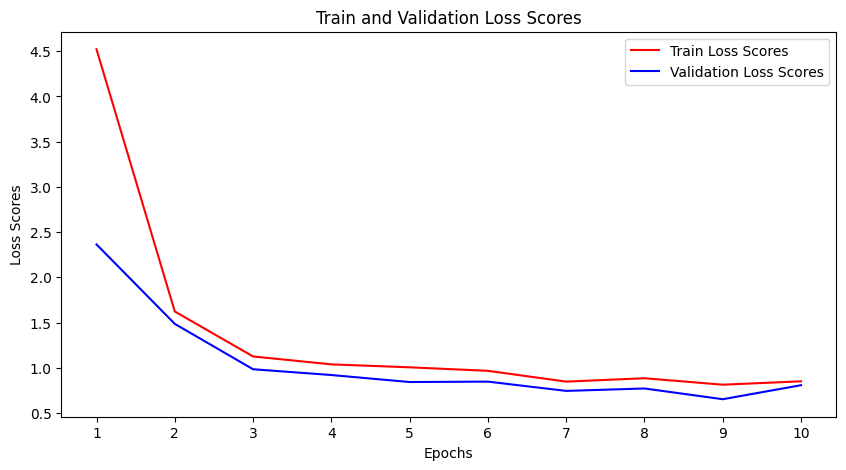

<Figure size 640x480 with 0 Axes>

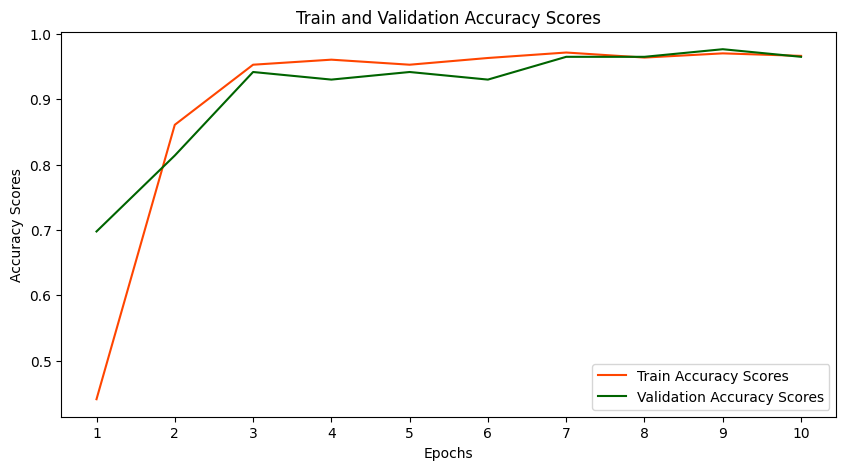

<Figure size 640x480 with 0 Axes>

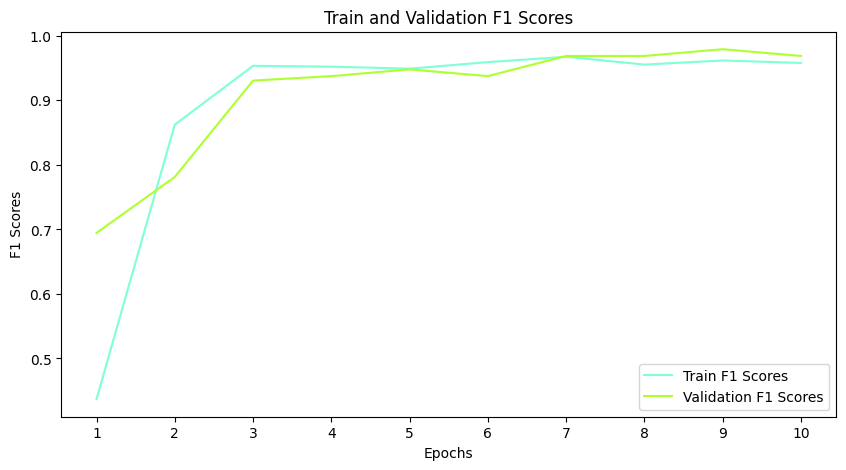

<Figure size 640x480 with 0 Axes>

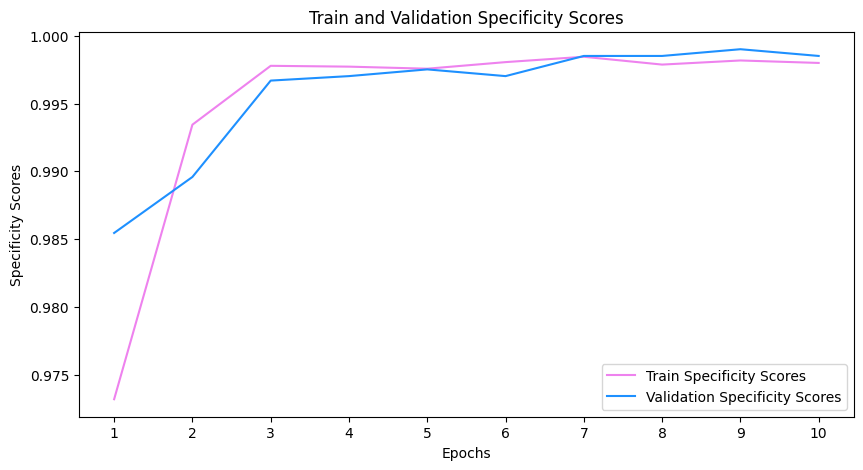

<Figure size 640x480 with 0 Axes>

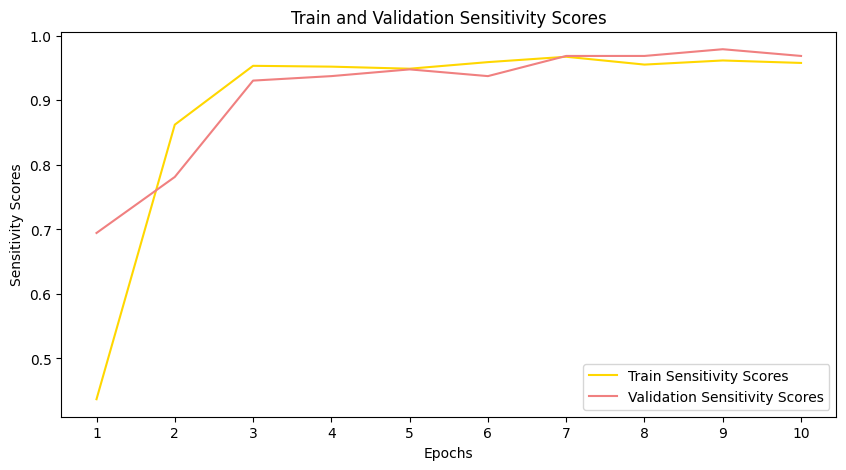

<Figure size 640x480 with 0 Axes>

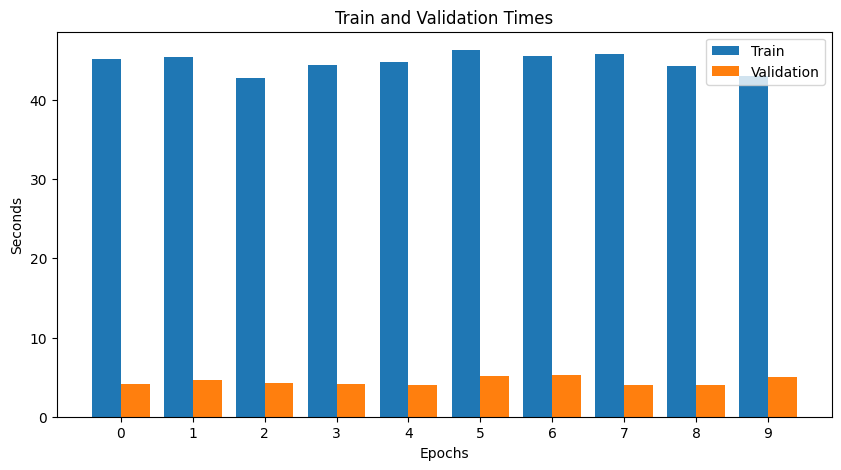

Learning curves can be found in stats

Train times can be found in stats directory under the name times.png



<Figure size 640x480 with 0 Axes>

In [ ]:
class TrainProcessSummary:

    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s,
                 val_f1s, tr_specs, val_spec, tr_sens, val_sens, tr_times,
                 vl_times, data_name, save_path = "stats"):

        self.makedirs(save_path)
        self.xlbl, self.times_sv_name   = "Epochs", "times.png"
        self.data_name, self.save_path  = data_name, save_path
        self.tr_losses, self.val_losses = tr_losses, val_losses
        self.tr_accs,   self.val_accs   = tr_accs, val_accs
        self.tr_f1s,    self.val_f1s    = tr_f1s, val_f1s
        self.tr_specs,  self.val_spec   = tr_specs, val_spec
        self.tr_sens,   self.val_sens   = tr_sens, val_sens
        self.tr_times,  self.vl_times   = tr_times, vl_times
        self.get_ticks_labels(); self.learning_curves(); self.bar_plot()

        print(f"Learning curves can be found in {self.save_path}\n")
        print(f"Train times can be found in {self.save_path} directory under the name {self.times_sv_name}\n")

    def get_ticks_labels(self): self.xtics, self.xlabels = np.arange(len(self.tr_losses)), [i for i in range(1, len(self.tr_losses) + 1)]

    def makedirs(self, path): os.makedirs(path, exist_ok = True)

    def create_figure(self):    plt.figure(figsize = (10, 5))

    def move2cpu(self, data):   return [d.cpu() for d in data]

    def plot(self, data1, data2, plot_name, c1, c2):

        self.create_figure()
        need2bemoved = ["Sensitivity", "Specificity", "F1"]
        if plot_name in need2bemoved: data1 = self.move2cpu(data1); data2 = self.move2cpu(data2)
        label = f"{plot_name} Scores"
        plt.plot(data1, label = f"Train {label}", color = c1); plt.plot(data2, label = f"Validation {label}", color = c2)
        plt.xlabel(self.xlbl); plt.ylabel(label); plt.title(f"Train and Validation {label}")
        plt.xticks(ticks = self.xtics, labels = self.xlabels); plt.legend(); plt.show()

    def save(self, save_name):

        sv_name = f"{self.data_name}_{save_name}"
        plt.savefig(f"{self.save_path}/{sv_name}")

    def learning_curves(self):

        self.plot(self.tr_losses, self.val_losses, "Loss",        "red",        "blue");         self.save("losses.png")
        self.plot(self.tr_accs,   self.val_accs,   "Accuracy",     "orangered",  "darkgreen");   self.save("accs.png")
        self.plot(self.tr_f1s,    self.val_f1s,    "F1",          "aquamarine", "greenyellow");  self.save("f1s.png")
        self.plot(self.tr_specs,  self.val_spec,   "Specificity", "violet",     "dodgerblue");   self.save("specs.png")
        self.plot(self.tr_sens,   self.val_sens,   "Sensitivity", "gold",       "lightcoral");   self.save("sens.png")

    def bar_plot(self):

        self.create_figure();

        plt.bar(self.xtics - 0.2, self.tr_times, 0.4, label = "Train")
        plt.bar(self.xtics + 0.2, self.vl_times, 0.4, label = "Validation")

        plt.xticks(self.xtics);   plt.xlabel(self.xlbl)
        plt.ylabel("Seconds");    plt.title("Train and Validation Times")
        plt.legend(); plt.show(); self.save(self.times_sv_name)

TrainProcessSummary(*results, data_name = data_name)

# ✅  Inference and AI Model Performance Analysis with GradCAM and Confusion Matrix ✅

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38340 sha256=24c5abd6377d18beccf9095b73c1f6e2b8a5c87788ed7a01400b78099143a5e2
  Stored in directory: /root/.cache/pip/wheels/5d/90/92/0661d038b2e6ce71cad21432f92c50b1d79887bd5eb82ff3b1
Successfully built grad-cam
Running inference...


87it [00:04, 19.96it/s]


Accuracy on the test data -> 0.989


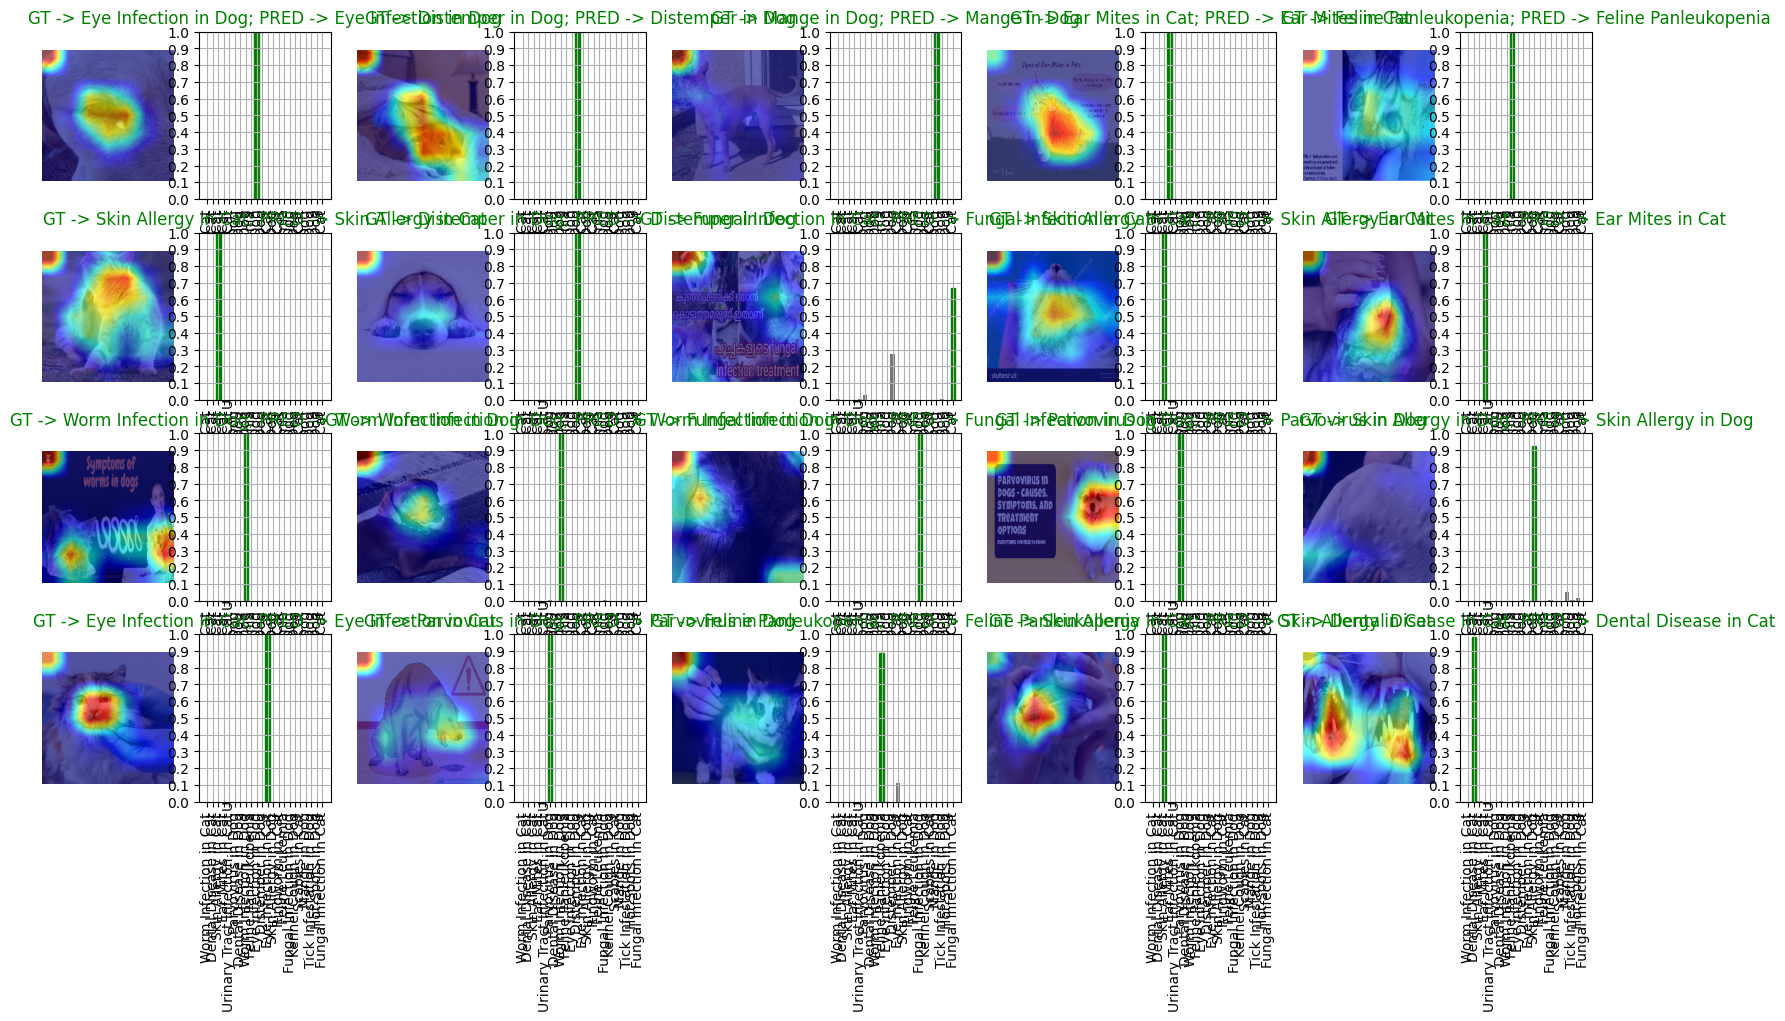

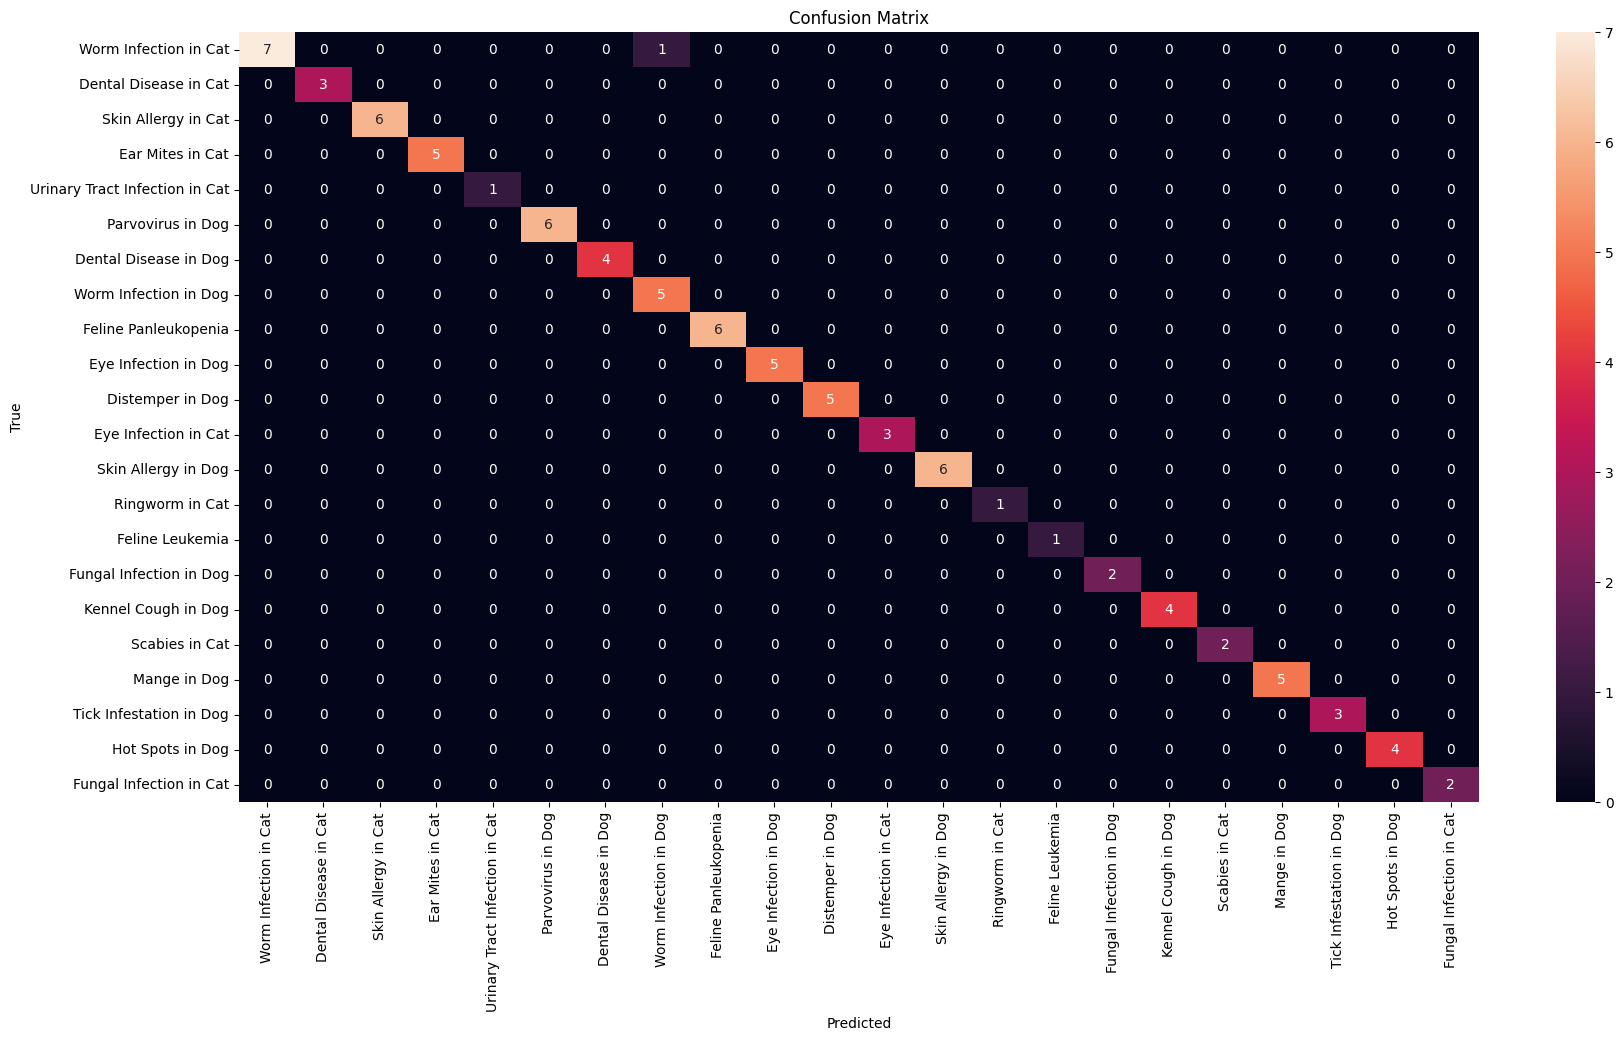

In [ ]:
!pip install grad-cam==1.4.6
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns

class Inference:
    def __init__(self, model, device, test_dl, cls_names=None, im_size=224):
        self.model = model.to(device)
        self.device = device
        self.test_dl = test_dl
        self.cls_names = cls_names
        self.im_size = im_size

    @staticmethod
    def tensor_2_im(t, t_type="rgb"):
        gray_tfs = T.Compose([
            T.Normalize(mean=[0.], std=[1/0.5]),
            T.Normalize(mean=[-0.5], std=[1])
        ])
        rgb_tfs = T.Compose([
            T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
            T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
        ])
        invTrans = gray_tfs if t_type == "gray" else rgb_tfs
        return (invTrans(t) * 255).detach().squeeze().cpu().permute(1, 2, 0).numpy().astype(np.uint8)

    @staticmethod
    def plot_value_array(logits, gt, cls_names):
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred_score, pred_class = torch.max(probs, dim=1)

        plt.grid(visible=True)
        plt.xticks(range(len(cls_names)), cls_names, rotation='vertical')
        plt.yticks(np.arange(0., 1.01, 0.1))
        bar = plt.bar(range(len(cls_names)), [p.item() for p in probs[0]], color="#777777")
        plt.ylim([0, 1])
        bar[pred_class].set_color('green' if pred_class.item() == gt else 'red')

    def run(self, num_ims, rows):
        self.model.eval()
        with torch.no_grad():
            preds, images, lbls, logitss = [], [], [], []
            acc, count = 0, 1

            print("Running inference...")
            for idx, batch in tqdm(enumerate(self.test_dl)):
                # if idx == 3: break
                im, gt = batch["qry_im"].to(self.device), batch["qry_gt"].to(self.device)
                logits = self.model(im)
                pred_class = torch.argmax(logits, dim=1)
                acc += (pred_class == gt).sum().item()
                images.append(im)
                logitss.append(logits)
                preds.append(pred_class.item())
                lbls.append(gt.item())

            print(f"Accuracy on the test data -> {(acc / len(self.test_dl.dataset)):.3f}")

        # Grad-CAM Visualization
        plt.figure(figsize=(20, 10))
        cam = GradCAM(model=self.model, target_layers=[self.model.features[-1].conv], use_cuda=True)
        indices = [random.randint(0, len(images) - 1) for _ in range(num_ims)]
        for idx, index in enumerate(indices):
            im = self.tensor_2_im(images[index].squeeze())
            pred_idx = preds[index]

            # Visualize input image
            plt.subplot(rows, 2 * num_ims // rows, count)
            count += 1
            plt.imshow(im, cmap="gray")
            plt.axis("off")

            # Grad-CAM Visualization
            grayscale_cam = cam(input_tensor=images[index])[0, :]
            visualization = show_cam_on_image(im / 255, grayscale_cam, image_weight=0.4, use_rgb=True)
            plt.imshow(visualization)
            plt.axis("off")

            # Plot Prediction Probabilities
            plt.subplot(rows, 2 * num_ims // rows, count)
            count += 1
            self.plot_value_array(logits=logitss[index], gt=lbls[index], cls_names=self.cls_names)

            if self.cls_names:
                gt_label = self.cls_names[int(lbls[index])]
                pred_label = self.cls_names[int(preds[index])]
                title_color = "green" if gt_label == pred_label else "red"
                plt.title(f"GT -> {gt_label}; PRED -> {pred_label}", color=title_color)
            else:
                plt.title(f"GT -> {lbls[index]}; PRED -> {preds[index]}")

        # Plot Confusion Matrix
        plt.figure(figsize=(20, 10))
        cm = confusion_matrix(lbls, preds)
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=self.cls_names, yticklabels=self.cls_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

model = timm.create_model(model_name=model_name, num_classes=len(classes))
model.load_state_dict(torch.load(f"{save_dir}/{data_name}_{run_name}_{model_name}_best_model.pth"))
model.eval()
inference_runner = Inference(model=model, device=device, test_dl=ts_dl, cls_names=list(classes.keys()))
inference_runner.run(num_ims=20, rows=4)